In [ ]:
import spacy
from keybert import KeyBERT
from transformers import pipeline
import typing as tp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
classifier = pipeline(
    "zero-shot-classification",
    model="facebook/bart-large-mnli"
)

Device set to use mps:0


In [3]:
nlp = spacy.load("en_core_web_sm", disable=["parser", "tagger", "lemmatizer"])

In [4]:
keybert = KeyBERT(model="all-MiniLM-L6-v2")

In [5]:
ngram_range = (1, 1)
top_n_keywords = 5
zero_shot_threshold = 0.2

In [6]:
def analyze(text: str) -> dict[str, tp.Any]:
    doc = nlp(text)
    entities = [(ent.text, ent.label_) for ent in doc.ents]

    raw_keywords = keybert.extract_keywords(
        text,
        keyphrase_ngram_range=ngram_range,
        stop_words="english",
        top_n=top_n_keywords,
    )
    candidate_labels = [phrase for phrase, score in raw_keywords]

    zs = classifier(
        sequences=text,
        candidate_labels=candidate_labels,
        multi_label=True
    )
    labels, scores = [], []
    for label, score in zip(zs["labels"], zs["scores"]):
        if score >= zero_shot_threshold:
            labels.append(label)
            scores.append(score)

    return {
        "entities": entities,
        "keywords": [{"keyword": k, "semantic_score": s} for k, s in raw_keywords],
        "topics": [{"label": l, "score": s} for l, s in zip(labels, scores)]
    }

In [7]:
texts = [
    "Tech company Microsoft announced its quarterly earnings on Wednesday, reporting revenue of $41.7 billion. CEO Satya Nadella highlighted AI integration in all major products and services.",
    "During his visit to Paris, Elon Musk toured the Louvre Museum, praising art history and discussing SpaceX’s next Mars mission with French officials at the French Ministry of Culture.",
    "In the 2024 Paris Olympics opening ceremony, gymnast Simone Biles captivated the audience with a breathtaking performance at Stade de France, setting a new record.",
    "Starbucks unveiled its new sustainability plan in Nairobi, Kenya, promising to source 50% of coffee beans from environmentally certified farms by 2030, and partnering with local farmers.",
    "Apple’s release of the iPhone 15 Pro featuring a titanium frame and periscope lens generated huge interest among photographers and tech enthusiasts at WWDC in Cupertino.",
]

In [8]:
results = []
for i, text in enumerate(texts, start=1):
    res = analyze(text)
    res["message_id"] = f"Msg {i}"
    results.append(res)

In [9]:
entities_data = []
for r in results:
    for ent_text, ent_label in r["entities"]:
        entities_data.append(
            {
                "Message": r["message_id"],
                "Entity": ent_text,
                "Type": ent_label
            }
        )

In [10]:
keywords_data = []
for r in results:
    for kw in r["keywords"]:
        keywords_data.append(
            {
                "Message": r["message_id"],
                "Keyword": kw["keyword"],
                "SemanticScore": kw["semantic_score"]
            }
        )

In [11]:
topics_data = []
for r in results:
    for topic in r["topics"]:
        topics_data.append(
            {
                "Message": r["message_id"],
                "Topic": topic["label"],
                "Score": topic["score"]
            }
        )

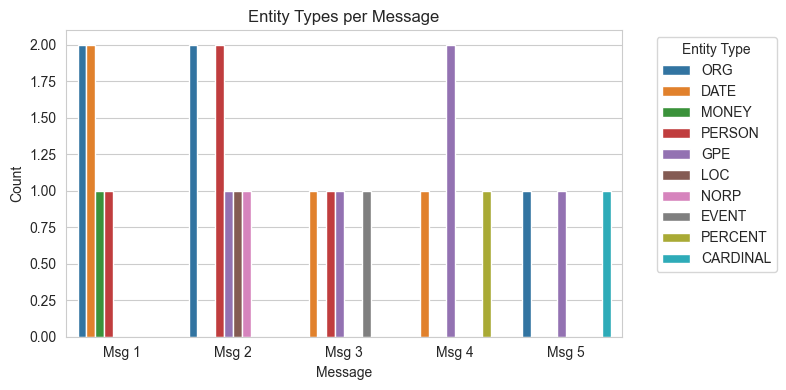

In [12]:
df_entities = pd.DataFrame(entities_data)

plt.figure(figsize=(8, 4))
sns.countplot(data=df_entities, x="Message", hue="Type")

plt.title("Entity Types per Message")
plt.ylabel("Count")
plt.legend(title="Entity Type", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()

plt.show()

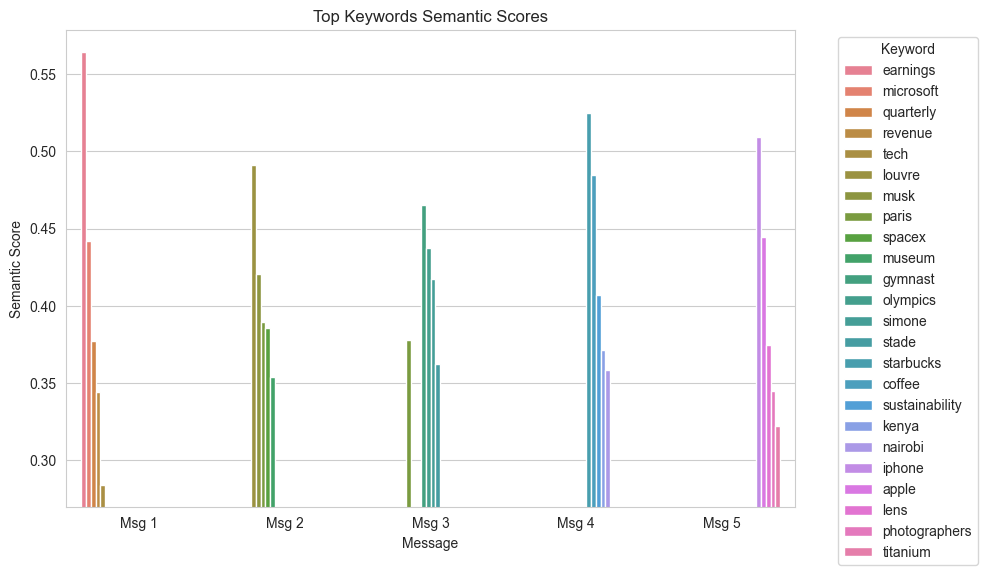

In [20]:
df_keywords = pd.DataFrame(keywords_data)

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=df_keywords,
    x="Message",
    y="SemanticScore",
    hue="Keyword"
)

plt.title("Top Keywords Semantic Scores")
plt.ylabel("Semantic Score")

min_score = df_keywords["SemanticScore"].min()
max_score = df_keywords["SemanticScore"].max()
margin = (max_score - min_score) * 0.05

ax.set_ylim(min_score - margin, max_score + margin)

plt.legend(title="Keyword", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

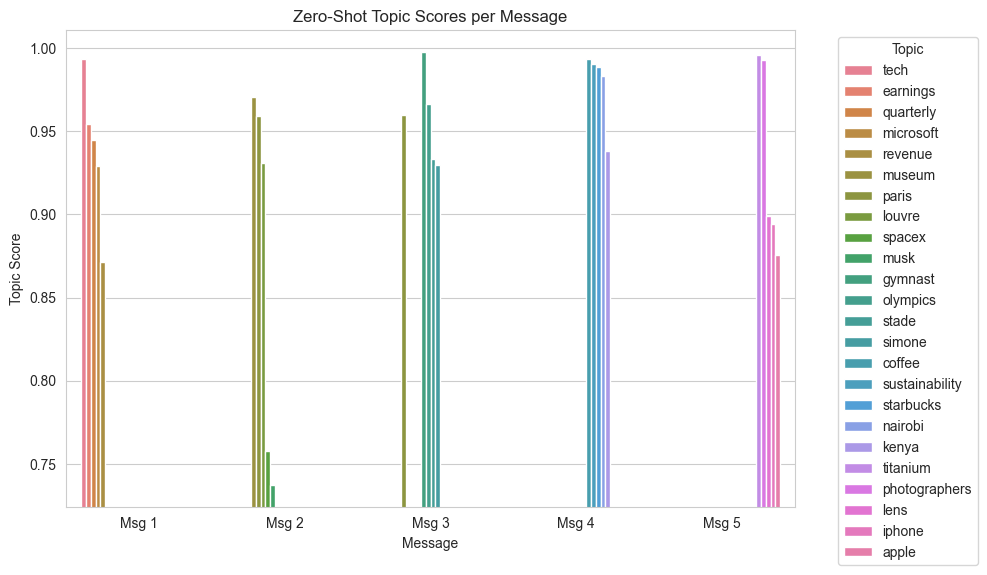

In [19]:
df_topics = pd.DataFrame(topics_data)

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=df_topics,
    x="Message",
    y="Score",
    hue="Topic"
)
plt.title("Zero-Shot Topic Scores per Message")
plt.ylabel("Topic Score")

min_score = df_topics["Score"].min()
max_score = df_topics["Score"].max()
margin = (max_score - min_score) * 0.05

ax.set_ylim(min_score - margin, max_score + margin)

plt.legend(title="Topic", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()